In [166]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [71]:
block_size = 3
X, Y = [], []
for w in words:
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [72]:
X.shape, X.dtype, Y.shape, Y.dtype


(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [10]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

In [120]:
block_size = 3

def build_dataset(words):
  X, Y = [], []
  for w in words:

    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [11]:
C = torch.randn((27,2))

In [73]:
emb =C[X]
emb.shape

torch.Size([228146, 3, 2])

In [74]:
W1 = torch.randn((6,100))
b1 = torch.randn(100)

In [75]:
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
h

tensor([[ 0.9866, -1.0000, -1.0000,  ...,  0.9999,  1.0000, -0.0331],
        [ 0.9400, -0.9396, -1.0000,  ...,  0.9962,  0.9402, -1.0000],
        [ 0.7693, -1.0000, -0.9581,  ...,  0.9987,  1.0000, -0.9978],
        ...,
        [ 0.5500,  0.9724,  0.0953,  ...,  0.3467,  0.9163, -0.9980],
        [-0.9756,  0.4371,  0.9986,  ...,  0.0548,  0.9780, -0.9196],
        [ 0.9357,  0.9930,  0.9465,  ..., -0.9503, -0.8176,  0.9989]],
       grad_fn=<TanhBackward0>)

In [76]:
h.shape

torch.Size([228146, 100])

In [77]:
W2 = torch.randn(100,27)
b2 = torch.randn(27)

In [78]:
logits = h @ W2 + b2

In [79]:
logits.shape

torch.Size([228146, 27])

In [80]:
counts = logits.exp()
prob = counts / counts.sum(1,keepdim=True)

In [81]:
prob.shape

torch.Size([228146, 27])

In [121]:
# Cleaner

Xtr.shape, Ytr.shape


(torch.Size([182625, 3]), torch.Size([182625]))

In [152]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g, requires_grad=True)
W1 = torch.randn((30, 200), generator=g, requires_grad=True)
b1 = torch.randn(200, generator=g, requires_grad=True)
W2 = torch.randn((200, 27), generator=g, requires_grad=True)
b2 = torch.randn(27, generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]

In [153]:
sum(p.nelement() for p in parameters)

11897

In [154]:
for p in parameters:
  p.required_grad = True

In [135]:
lre = torch.linspace(-3,0,1000)
lrs = 10**lre

In [155]:
lri = []
lossi = []
stepi = []

In [169]:

for i in range(50000):

  ix = torch.randint(0, Xtr.shape[0], (32,))

  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1,30) @ W1 + b1)
  logits = h @ W2 + b2
  #counts = logits.exp()
  #prob = counts / counts.sum(1,keepdim=True)
  loss = F.cross_entropy(logits, Ytr[ix])
  for p in parameters:
    p.grad = None
  loss.backward()

  lr = 0.01
  for p in parameters:
    p.data += -lr * p.grad

  stepi.append(i)
  lossi.append(loss.log10().item())
print(loss.item())



2.364365339279175


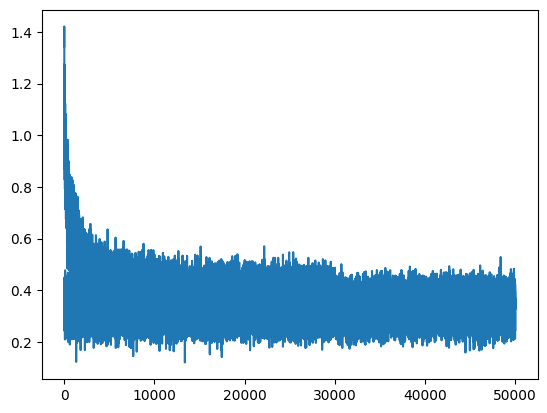

In [164]:
plt.plot(stepi,lossi)

In [165]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2043, grad_fn=<NllLossBackward0>)

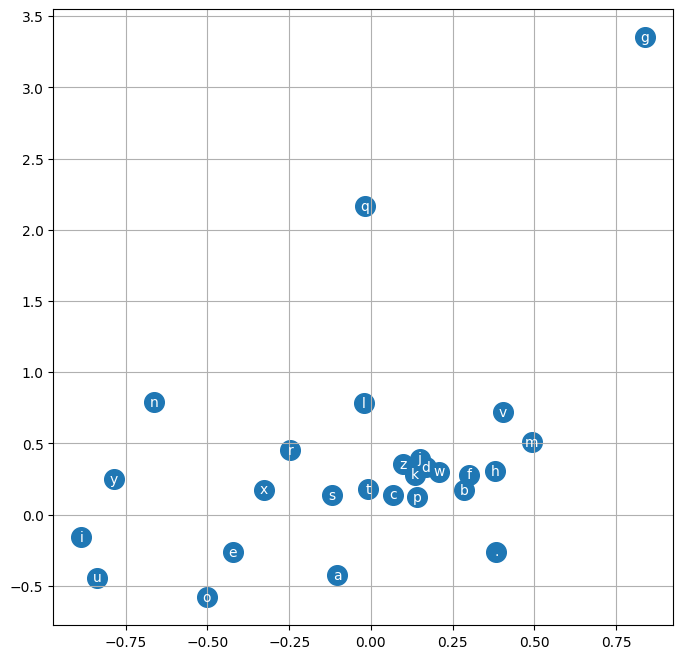

In [151]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [170]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

mora.
mayah.
see.
mad.
rylle.
emmaniendraeg.
azeredieliah.
milopaleigh.
van.
aar.
kayzion.
kalin.
shubvigahiries.
kin.
renderlen.
puctou.
zence.
riyah.
faeha.
kayjahsanyah.
